In [58]:
import re
from collections import OrderedDict
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import pandas as pd
MAX_WORDS_WORDCLOUD =100
#

In [59]:
dataset_to_process = "MANNHEIM" # "MANNHEIM" LINVILL

In [60]:
from sqlalchemy import create_engine, inspect
engine = create_engine(f'sqlite:///{dataset_to_process}.sqlite')
connection = engine.connect()
print(engine.table_names())
inspector = inspect(connection)


[]


# Loading of dataset from Helm and Paulheim

In [61]:
if dataset_to_process == "MANNHEIM":
    CLUSTERS_TO_TRY=[5,6]
    MINIMUM_TWEETS_PER_ACCOUNT=1
    PROCESS_MAX_TWEETS_PER_ACCOUNT=100000
    RANDOMIZE_TWEET_ORDER=False
    MIN_DF = 0.01 #0.4
    MAX_FEATURES= 100 #100
    overrideClusterSelection = "random6cosine"

The dataset is described at https://github.com/s-helm/TwitterFakeNews,  but the data need to be downloaded from http://data.dws.informatik.uni-mannheim.de/fakenews/.

In [62]:
if dataset_to_process == "MANNHEIM":
    tablename = "tweets"
    if not tablename in engine.table_names():
        inputFile = "mannheim/data_set_tweet_user_features.csv"
        df = pd.read_csv(inputFile, sep=";")
        df.to_sql(name=tablename, con=connection, if_exists='append', index=True)
    else:
        print("already present in database")

### Rename the fields so that the names match names used in Linvill and Warren

In [63]:
if dataset_to_process == "MANNHEIM":
    columns = inspector.get_columns(tablename)
    colnames =[]
    for column in columns:
        colnames.append(column["name"])
    if "tweet__sent_tokenized_text" in colnames: 
        troll_sql = f"""
        ALTER TABLE '{tablename}'
        RENAME COLUMN tweet__sent_tokenized_text to content;"""
        cursor = connection.execute(troll_sql)
        troll_sql = f"""
            ALTER TABLE '{tablename}'
            RENAME COLUMN user__screen_name to author;"""
        cursor = connection.execute(troll_sql)
    if "tweet__lang" in colnames: 
        troll_sql = f"""
        ALTER TABLE '{tablename}'
        RENAME COLUMN tweet__lang to language;"""
        cursor = connection.execute(troll_sql)
    # here the category is fake or not fake, different from Linvill and Warren
    # todo: check if all tweets of the account are marked as fake if at least one is marked as fake 
    if "tweet__fake" in colnames: 
        troll_sql = f"""
        ALTER TABLE '{tablename}'
        RENAME COLUMN tweet__fake to account_category;"""
        cursor = connection.execute(troll_sql)
    # Not sure if tweet__retweeted corresponds to retweet
    if "tweet__retweeted" in colnames: 
        troll_sql = f"""
            ALTER TABLE '{tablename}'
            RENAME COLUMN tweet__retweeted to retweet;"""
        cursor = connection.execute(troll_sql)

# Loading of dataset from Linvill and Warren

The dataset needs to be copied from https://github.com/fivethirtyeight/russian-troll-tweets

In [64]:
if dataset_to_process == "LINVILL":
    CLUSTERS_TO_TRY=[5,6]
    MINIMUM_TWEETS_PER_ACCOUNT=100 # use only accounts with greater than this tweets
    PROCESS_MAX_TWEETS_PER_ACCOUNT = 100 # 100000
    RANDOMIZE_TWEET_ORDER=True
    MIN_DF = 0.4 #as in the original experiment for user study
    MAX_FEATURES= None #as in the original experiment for user study
    overrideClusterSelection = "random6cosine"
    tablename= "tweets"
    if not tablename in engine.table_names():
        for i in range(1,14):
            inputFile = "russian-troll-tweets-master/IRAhandle_tweets_" + str(i) +".csv"
            print(inputFile)
            df = pd.read_csv(inputFile)
            #print("randomly selecting subset of data")
            #df=df.sample(random_state=42,frac=0.01)
            df.to_sql(name=tablename, con=connection, if_exists='append', index=True)
    else:
        print("already present in database")

# Statistics

## Total acounts, tweets, and average number of tweets per category 

In [65]:
# selects number of accounts and number of tweets, average number of tweets per account (English tweets without retweets)
troll_sql = """
select account_category, count(*) as total_accounts, sum(tweet_cnt), sum(tweet_cnt)/count(*) 
as avg_tweets_per_account   from (
select
 account_category, author, count(*) as tweet_cnt
from tweets
where retweet = 0 and (language = 'English' or language = 'en')
group by account_category, author) 
group by account_category
"""
cursor = connection.execute(troll_sql)
result = cursor.fetchall()
result

[(0, 45, 144771, 3217), (1, 55, 55229, 1004)]

## Total acounts, tweets, and average number of tweets per category considering only accounts with preset minimum number of tweets

In [66]:
# selects number of accounts and number of tweets, average number of tweets per account (English tweets without retweets)
# ONLY
troll_sql = f"""
select account_category, count(*) as total_accounts, sum(tweet_cnt), sum(tweet_cnt)/count(*) 
as avg_tweets_per_account   from (
select
 account_category, author, count(*) as tweet_cnt
from tweets
where retweet = 0 and (language = 'English' or language = 'en')
group by account_category, author
) 
where tweet_cnt >= {MINIMUM_TWEETS_PER_ACCOUNT} 
group by account_category 
"""
cursor = connection.execute(troll_sql)
result = cursor.fetchall()
result

[(0, 45, 144771, 3217), (1, 55, 55229, 1004)]

## Are there any accounts with tweets in more than one category? 

In [67]:
# selects number of accounts and number of tweets, average number of tweets per account (English tweets without retweets)
mixed_cats = f"""
select author from 
(select
 count(DISTINCT account_category) as cats, author
from tweets
where retweet = 0 and (language = 'English' or language = 'en') 
group by author)
where 
cats!=1
"""
cursor = connection.execute(mixed_cats)
authors_mix_result = cursor.fetchall()
authors_mix = [a[0]  for a in authors_mix_result]

In [68]:
# Yes for Helm and Paulheim, No for Linvill and Warren

In [69]:
authors_mix

['AlterNet',
 'CatoInstitute',
 'ChristianPost',
 'TheAdvocateMag',
 'amprog',
 'nutrition_facts']

# Create a new table for distinct authors

In [70]:
tablename= "tweets_authors"
troll_sql = """drop table IF EXISTS tweets_authors;"""
cursor = connection.execute(troll_sql)
troll_sql = """
create table tweets_authors as
select
author, account_category, count(*) as tweet_cnt
from tweets
where retweet = 0 and (language = 'English' or language = 'en')
group by author;"""
cursor = connection.execute(troll_sql)

In [71]:
cursor = connection.execute(f"select author from tweets_authors where tweet_cnt >= {MINIMUM_TWEETS_PER_ACCOUNT}")
authors = [author for (author, ) in cursor]
len(authors)

94

In [72]:
tablename= "tweets_sample"
troll_sql = """drop table IF EXISTS tweets_sample;"""
cursor = connection.execute(troll_sql)

if RANDOMIZE_TWEET_ORDER:
    randSQL="order by random()"
else:
    randSQL = ""
if not tablename in engine.table_names(): # this line is not needed if the drop is present
    connection.execute(f"CREATE TABLE tweets_sample (content varchar({PROCESS_MAX_TWEETS_PER_ACCOUNT * 150}), author varchar(255), account_category varchar(255));")
    for author in authors:
        print(author)
        connection.execute(f"""
        insert into tweets_sample (content, author, account_category)
        select content, author, account_category from tweets
        where author = '{author}' 
        {randSQL} limit {PROCESS_MAX_TWEETS_PER_ACCOUNT};
        """)
        r= connection.execute(f"""
        select count(*) from tweets_sample
        """)


ABC
AlterNet
BBCBreaking
BarnPat
BarracudaMama
BurrardStreetJ
CBSNews
CNewsExaminer
COED
CRG_CRM
CatoInstitute
ChristWire
ChristianPost
ClickHole
ControversialF
DCClothesline
DailyBuzzLive
DailySurge
Duh_Progressive
EmpireSportsNet
EverettHerald
FPRNRadio
FoxNews
GOPLADYAMY
GeoengWatch
IfYou0nlyNews
ImmSafety
KRBNNews
LibertyBlitz
LightAlexander
MIReporter
MSNBC
Middletownpress
MorrisHerald
NBCNews
NPR
NeonNettle
NewYorker
NewsBiscuit
NewsHour
OANN
PamelaGeller
PrepperWebsite
PrivateEyeNews
RHobbusJD
RealAlexJones
RecordPilot
RickRWells
SCGupdates
SatiraTribune
SputnikInt
StarAdvertiser
TheAdvocateMag
TheAspenTimes
TheEconomist
TheGeorgetownr
TheHuzlers
TheInTowner
TheNYevening
TheRecorderNews
USATODAY
WSJ
YahooNews
amprog
anonjekloy
beforeitsnews
boroherald
business
cnnbrk
conserv_tribune
dahboo7
fakingnews
fusiontv
guardian
hangthebankers
infowars
monitornews
nationonenews
ncscooper
newhampshirecom
nutrition_facts
nytimes
politico
rilenews
rrstar
smag31woman
the_big_riddle
thedailyhe

#### check number of selected tweets

In [73]:
r= connection.execute(f"""
select count(*) from tweets_sample
""")
r.fetchall()

[(200000,)]

# Processing of preselected tweets 


### tweets in account are merged into one text

In [74]:
sql = 'select author, content, account_category from tweets_sample order by author'
cursor= connection.execute(sql)
#result = cursor.fetchall()
documents_dict = OrderedDict()
true_labels = []
# merge all tweets by one author into one entry 
authors=0
tweets=0
for (author, content, account_category) in cursor:
    if dataset_to_process == "MANNHEIM":
        if account_category =="0":
            account_category="real news"
        else:
            account_category="fake news"
    if author in documents_dict:
        if content != None:
            tweets=tweets+1
            documents_dict[author] += '\n' + content
            #if the tweet is in a different category than previously seen for this author
            #then reassign the author to the "mixed" category
            #this is applicable only for the Mannheim dataset, where
            #for several accounts some tweets are marked as 0 and some as 1
            if true_labels[len(true_labels)-1]!="mixed" and account_category != true_labels[len(true_labels)-1]:
                true_labels[len(true_labels)-1] = "mixed"
        else:
            print("Skipped empty content")
    else:
        authors=authors+1
        tweets= tweets +1
        true_labels.append(account_category)
        documents_dict[author] = content
print("authors " + str(authors))
print("tweets " + str(tweets))

authors 94
tweets 200000


In [75]:
from collections import Counter
Counter(true_labels)

Counter({'real news': 39, 'mixed': 6, 'fake news': 49})

In [76]:
list(zip(documents_dict.keys(),true_labels))

[('ABC', 'real news'),
 ('AlterNet', 'mixed'),
 ('BBCBreaking', 'real news'),
 ('BarnPat', 'real news'),
 ('BarracudaMama', 'fake news'),
 ('BurrardStreetJ', 'fake news'),
 ('CBSNews', 'real news'),
 ('CNewsExaminer', 'fake news'),
 ('COED', 'fake news'),
 ('CRG_CRM', 'fake news'),
 ('CatoInstitute', 'mixed'),
 ('ChristWire', 'fake news'),
 ('ChristianPost', 'mixed'),
 ('ClickHole', 'fake news'),
 ('ControversialF', 'fake news'),
 ('DCClothesline', 'fake news'),
 ('DailyBuzzLive', 'fake news'),
 ('DailySurge', 'fake news'),
 ('Duh_Progressive', 'fake news'),
 ('EmpireSportsNet', 'fake news'),
 ('EverettHerald', 'real news'),
 ('FPRNRadio', 'fake news'),
 ('FoxNews', 'real news'),
 ('GOPLADYAMY', 'fake news'),
 ('GeoengWatch', 'fake news'),
 ('IfYou0nlyNews', 'fake news'),
 ('ImmSafety', 'fake news'),
 ('KRBNNews', 'real news'),
 ('LibertyBlitz', 'fake news'),
 ('LightAlexander', 'fake news'),
 ('MIReporter', 'real news'),
 ('MSNBC', 'real news'),
 ('Middletownpress', 'real news'),
 ('M

In [77]:
true_labels

['real news',
 'mixed',
 'real news',
 'real news',
 'fake news',
 'fake news',
 'real news',
 'fake news',
 'fake news',
 'fake news',
 'mixed',
 'fake news',
 'mixed',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'real news',
 'fake news',
 'real news',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'real news',
 'fake news',
 'fake news',
 'real news',
 'real news',
 'real news',
 'real news',
 'real news',
 'real news',
 'fake news',
 'real news',
 'fake news',
 'real news',
 'real news',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'real news',
 'fake news',
 'fake news',
 'fake news',
 'fake news',
 'real news',
 'mixed',
 'real news',
 'real news',
 'real news',
 'fake news',
 'real news',
 'fake news',
 'real news',
 'real news',
 'real news',
 'real news',
 'mixed',
 'fake news',
 'fake news',
 'real news',
 'real news',
 'real news',
 'fake news',
 'fake news',
 'fake news',
 'real news'

In [78]:
class TrollTfidfVectorizer(TfidfVectorizer):

    def __init__(self, *args, **kwargs):
        troll_stop_words = {'don', 'just', 'like'} # the custom stop word list could be further expanded
        kwargs['stop_words'] = set(ENGLISH_STOP_WORDS).union(troll_stop_words)
        kwargs['preprocessor'] = self.vectorizer_preprocess
        self.wnl = WordNetLemmatizer()
        super(TrollTfidfVectorizer, self).__init__(*args, **kwargs)

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: ([self.wnl.lemmatize(w) for w in analyzer(doc)])

    def vectorizer_preprocess(self, s):
        # remove urls
        s = re.sub(r'(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?', '', s)
        # remove amp
        s = s.replace('&amp;', '')
        # remove RT signs (no meaning) but keep username
        s = re.sub(r'\bRT\b\s+', '', s)
        s = s.lower()
        return s

In [79]:
origVectorized=TrollTfidfVectorizer().fit_transform(documents_dict.values())
origVectorized

<94x56152 sparse matrix of type '<class 'numpy.float64'>'
	with 311540 stored elements in Compressed Sparse Row format>

In [80]:
vectorizer = TrollTfidfVectorizer(max_features=MAX_FEATURES, min_df=MIN_DF)
doc_term_matrix = vectorizer.fit_transform(documents_dict.values())
doc_term_matrix


<94x100 sparse matrix of type '<class 'numpy.float64'>'
	with 6132 stored elements in Compressed Sparse Row format>

In [81]:
if doc_term_matrix.shape[1] > MAX_WORDS_WORDCLOUD:
    print("Dimensionality is too high, consider increasing MIN_DF or decreasing MAX_FEATURES")

# Choosing the optimal number of clusters
In the original experiment, this phase resulted in a short listing of five and six clusters


In [82]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as pl

model_scores = [] # "-within-cluster sum of squares" (the higher the better fit - because it is negative)

# value near +1 indicate that the sample is far away from the neighboring clusters.
# A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
# negative values indicate that those samples might have been assigned to the wrong cluster
model_silhouettes = [] 

clusters_range = range(2, 30)

# test cluster sizes
for n_clusters in clusters_range:
    print(f'Test clustering with {n_clusters}')

    model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1)
    cluster_labels = model.fit_predict(doc_term_matrix)

    score = model.score(doc_term_matrix)
    print(f'Model score is {model.score(doc_term_matrix)}')
    model_scores.append(score)

    silhouette_avg = silhouette_score(doc_term_matrix, cluster_labels)
    model_silhouettes.append(silhouette_avg)
    print(f'Avg silhouette score is {silhouette_avg}')


Test clustering with 2
Model score is -48.732754265255416
Avg silhouette score is 0.16882070728393073
Test clustering with 3
Model score is -46.34509677555865
Avg silhouette score is 0.05205029666126155
Test clustering with 4
Model score is -43.52375020013487
Avg silhouette score is 0.07185756742618848
Test clustering with 5
Model score is -42.04432574293679
Avg silhouette score is 0.07622723580431404
Test clustering with 6
Model score is -41.19476265326851
Avg silhouette score is 0.06925841001999587
Test clustering with 7
Model score is -41.245757545881474
Avg silhouette score is 0.10983383860935679
Test clustering with 8
Model score is -38.96496795887093
Avg silhouette score is 0.05562289656545589
Test clustering with 9
Model score is -38.4609563406572
Avg silhouette score is 0.06576337928545727
Test clustering with 10
Model score is -36.56519368784545
Avg silhouette score is 0.07269053267721036
Test clustering with 11
Model score is -36.384311568436864
Avg silhouette score is 0.0757

# Elbow curve

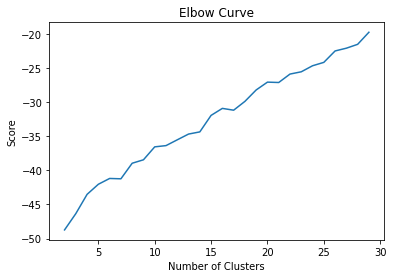

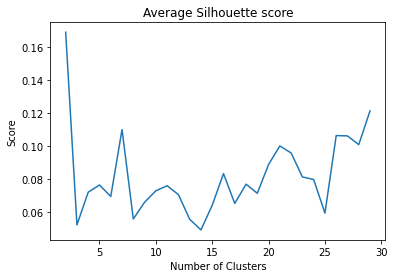

In [83]:
pl.plot(clusters_range, model_scores)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

pl.plot(clusters_range, model_silhouettes)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Average Silhouette score')
pl.show()


# Evaluation of clustering combinations and selection of the best

Finds the best combination and selects it

In [84]:
# Metrics                    
from sklearn.metrics import adjusted_rand_score,\
    silhouette_score, davies_bouldin_score,\
    calinski_harabasz_score, v_measure_score, fowlkes_mallows_score

def evalCluster(doc_term_matrix,cluster_labels,true_labels, tag):
    silhouette_avg = silhouette_score(doc_term_matrix, cluster_labels)  #smaller value better
    db_index = davies_bouldin_score(data, cluster_labels)# greater value better
    vrc = calinski_harabasz_score(data, cluster_labels) #smaller value better
    adjusted_rand = adjusted_rand_score(true_labels, cluster_labels) #smaller value better
    v_measure = v_measure_score(true_labels, cluster_labels) #smaller value better
    fm_score = fowlkes_mallows_score(true_labels, cluster_labels)  #smaller value better
    return (pd.DataFrame([silhouette_avg,db_index,vrc,adjusted_rand,v_measure,fm_score], columns=[tag],index=["silhouette_avg","db_index","vrc","adjusted_rand","v_measure","fm_score"]))

In [85]:
#def l2norm(doc_term_matrix):
    #the data on input are already l2 normalized
    #https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python
#    length = np.sqrt((doc_term_matrix**2).sum(axis=1))[:,None]
#    data = doc_term_matrix / length
#    data=np.nan_to_num(data)
#    return(data)

In [86]:
import numpy as np
from itertools import compress
zerorows=np.where(np.sum(np.abs(doc_term_matrix), axis=1)==0)[0]
if zerorows.size>0:
    nonzerovectors=doc_term_matrix.getnnz(1)!=0
    print("removing entries with all zero feature vectors")
    print(zerorows)
    doc_term_matrix= doc_term_matrix[nonzerovectors]
    cluster_labels=cluster_labels[nonzerovectors]
    true_labels = list(compress(true_labels, nonzerovectors))

removing entries with all zero feature vectors
[ 7 19 25]


In [87]:
import numpy as np
data=doc_term_matrix.toarray()
from nltk.cluster import KMeansClusterer, cosine_distance
import random
dfStats = pd.DataFrame(index=["silhouette_avg","db_index","vrc","adjusted_rand","v_measure","fm_score"], columns=[])
models=[]
for n_clusters in CLUSTERS_TO_TRY:
    for distance in ["euclidean","cosine"]:
        for init in ["k-means++","random"]:
            tag=init+ str(n_clusters) + distance
            seed=42    
            if distance=="cosine":
                if init == "k-means++":
                    continue #this combination is not supported
                rng = random.Random()
                rng.seed(seed)
                model = KMeansClusterer(n_clusters, distance=cosine_distance,repeats=25, avoid_empty_clusters=True,  rng = rng)  
                cluster_labels = model.cluster(data, assign_clusters=True)
            else:
                model = KMeans(n_clusters=n_clusters, random_state=seed, init=init, n_init=25)
                model = model.fit(data)
                cluster_labels = model.predict(data)
            models.append(model)
            _df=evalCluster(data,cluster_labels,true_labels, tag)
            dfStats=pd.concat([dfStats,_df], axis=1)

In [88]:
dfStats


,k-means++5euclidean,random5euclidean,random5cosine,k-means++6euclidean,random6euclidean,random6cosine
silhouette_avg,0.063047,0.062619,0.073444,0.078778,0.072907,0.068318
db_index,2.453329,2.722354,2.446377,2.506758,2.217509,2.901799
vrc,7.844153,7.766318,6.937058,6.968024,6.850882,6.717017
adjusted_rand,0.137774,0.092137,0.073436,0.067343,0.022009,0.000263
v_measure,0.214857,0.183247,0.166888,0.158197,0.100844,0.049655
fm_score,0.413941,0.378702,0.435514,0.352183,0.348773,0.312636


In [89]:
from sklearn.cluster import AgglomerativeClustering
for n_clusters in CLUSTERS_TO_TRY:
    for affinity in ["euclidean","cosine"]:
        for linkage in ["average","complete","single"]:
            model = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity,
                                            linkage=linkage)
            cluster_labels = model.fit_predict(data)
            models.append(model)
            _df=evalCluster(data,cluster_labels,true_labels, linkage  +str(n_clusters)+affinity)
            dfStats=pd.concat([dfStats,_df], axis=1)

In [90]:
# Functions for  

### Compute ranks

In [91]:
dfStats_rounded = round(dfStats,6)
dfStats_rounded #this is necessary to prevent very small differences to cause different rankings

,k-means++5euclidean,random5euclidean,random5cosine,k-means++6euclidean,random6euclidean,random6cosine,average5euclidean,complete5euclidean,single5euclidean,average5cosine,complete5cosine,single5cosine,average6euclidean,complete6euclidean,single6euclidean,average6cosine,complete6cosine,single6cosine
silhouette_avg,0.063047,0.062619,0.073444,0.078778,0.072907,0.068318,0.170255,0.172764,0.156287,0.165470,0.172764,0.156287,0.162440,0.176985,0.151604,0.157879,0.176985,0.151604
db_index,2.453329,2.722354,2.446377,2.506758,2.217509,2.901799,1.543666,2.269821,0.687457,1.427095,2.269821,0.687457,1.244275,2.032823,0.685315,1.147379,2.032823,0.685315
vrc,7.844153,7.766318,6.937058,6.968024,6.850882,6.717017,3.251472,7.408973,1.991534,2.986343,7.408973,1.991534,2.915920,6.604803,1.990448,2.698869,6.604803,1.990448
adjusted_rand,0.137774,0.092137,0.073436,0.067343,0.022009,0.000263,-0.027587,0.001600,-0.008120,-0.020815,0.001600,-0.008120,-0.027189,0.001222,-0.006724,-0.020420,0.001222,-0.006724
v_measure,0.214857,0.183247,0.166888,0.158197,0.100844,0.049655,0.038267,0.071150,0.059713,0.029821,0.071150,0.059713,0.059296,0.070626,0.072654,0.052036,0.070626,0.072654
fm_score,0.413941,0.378702,0.435514,0.352183,0.348773,0.312636,0.569572,0.408874,0.628559,0.586869,0.408874,0.628559,0.569662,0.407864,0.621840,0.586958,0.407864,0.621840


In [92]:
dfStats_rank=dfStats_rounded.rank(axis=1,ascending=False)
dfStats_rank.loc["db_index"] = dfStats_rounded.loc["db_index"].rank(ascending=True)

In [93]:
dfStats_rank

,k-means++5euclidean,random5euclidean,random5cosine,k-means++6euclidean,random6euclidean,random6cosine,average5euclidean,complete5euclidean,single5euclidean,average5cosine,complete5cosine,single5cosine,average6euclidean,complete6euclidean,single6euclidean,average6cosine,complete6cosine,single6cosine
silhouette_avg,17.0,18.0,14.0,13.0,15.0,16.0,5.0,3.5,9.5,6.0,3.5,9.5,7.0,1.5,11.5,8.0,1.5,11.5
db_index,15.0,17.0,14.0,16.0,11.0,18.0,8.0,12.5,3.5,7.0,12.5,3.5,6.0,9.5,1.5,5.0,9.5,1.5
vrc,1.0,2.0,6.0,5.0,7.0,8.0,11.0,3.5,15.5,12.0,3.5,15.5,13.0,9.5,17.5,14.0,9.5,17.5
adjusted_rand,1.0,2.0,3.0,4.0,5.0,10.0,18.0,6.5,13.5,16.0,6.5,13.5,17.0,8.5,11.5,15.0,8.5,11.5
v_measure,1.0,2.0,3.0,4.0,5.0,16.0,17.0,8.5,12.5,18.0,8.5,12.5,14.0,10.5,6.5,15.0,10.5,6.5
fm_score,10.0,15.0,9.0,16.0,17.0,18.0,8.0,11.5,1.5,6.0,11.5,1.5,7.0,13.5,3.5,5.0,13.5,3.5


In [94]:
#all measures
dfStats_rank.mean()

k-means++5euclidean     7.500000
random5euclidean        9.333333
random5cosine           8.166667
k-means++6euclidean     9.666667
random6euclidean       10.000000
random6cosine          14.333333
average5euclidean      11.166667
complete5euclidean      7.666667
single5euclidean        9.333333
average5cosine         10.833333
complete5cosine         7.666667
single5cosine           9.333333
average6euclidean      10.666667
complete6euclidean      8.833333
single6euclidean        8.666667
average6cosine         10.333333
complete6cosine         8.833333
single6cosine           8.666667
dtype: float64

# Purity and Silhouette for the selected clustering

In [95]:
def predict_uni(model,data):
    if hasattr(model, 'predict'): #in kmeans
        cluster_labels = model.predict(data)
    elif hasattr(model, 'fit_predict'): #Agglo clustering does not have predict, but relearning should give the same result as there is no random state
        cluster_labels = model.fit_predict(data) 
    else: #nltk
        cluster_labels = np.array(model.cluster(data, assign_clusters=True))
    return(cluster_labels)

In [96]:
from sklearn import metrics
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [97]:
np.round(np.array([1,2]),2)

array([1, 2])

In [98]:
from sklearn.metrics import silhouette_samples
def purity_silhouette(data,cluster_labels,true_labels):
    sil=silhouette_samples(data, cluster_labels)
    silbycluster=[]
    purbycluster=[]
    for i in np.unique(cluster_labels):
        silbycluster.append(np.mean(sil[cluster_labels==i]))
        purbycluster.append(purity_score(np.array(true_labels)[cluster_labels==i],cluster_labels[cluster_labels==i]))
    silbycluster     = np.round(np.array(silbycluster),2)
    purbycluster     = np.round(np.array(purbycluster),2)
    return(pd.DataFrame([silbycluster,purbycluster], index=["silhouette","purity"]))

In [99]:
def contingencytable (dataset_to_process,cluster_labels,true_labels,exportpath):
    if dataset_to_process == "LINVILL":
       colors = ["blue","pink","black","green","yellow","violet","red","grey"]
    else:
        colors=['red','blue','green']
    df = pd.DataFrame({'cluster': cluster_labels,
                       'category': true_labels})
    newdf=df.groupby(by=["cluster","category"]).size().unstack().reset_index().drop("cluster",axis=1)
    newdf = newdf.rename_axis("cluster",axis="columns")
    ax = newdf.plot.bar(stacked=True,color=colors)
    ax.set_ylabel("account count")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    ax.figure.savefig(f"{exportpath}.pdf",bbox_inches='tight')

# visualization definitions

In [100]:
# Word clouds
from wordcloud import WordCloud
import matplotlib.pyplot as pl

# this function is used both for standard word clouds and z-score word clouds
def wordcloud(dataframe, path, spectral=False, max_words=200,vertical =2,  horizontal =3):
    if dataframe.shape[0] == 5:
        vertical =1
        horizontal =5
    
    clusters_word_freq = []

    for index, row in dataframe.iterrows():
        freq_dict = {}
        for col_name in dataframe.columns:
            if row[col_name] > 0.00001:
                freq_dict[col_name] = float(row[col_name])
        clusters_word_freq.append(freq_dict)

    fig = pl.figure(figsize=(20, 10))
    for cluster, freq_dict in enumerate(clusters_word_freq):
        if spectral: #used for wordclouds from zscores, coolwarm goes from blue to red 
            def color_func(word, *args, **kwargs):
                cmap = pl.cm.get_cmap('coolwarm')
                #Colormap instances are used to convert data values (floats) from the interval [0, 1] to the RGBA color
                rgb = cmap(freq_dict[word] / 100, bytes=True)[0:3]                    
                return rgb
        else:
            color_func = None

        ax = fig.add_subplot(vertical, horizontal, cluster + 1)
        cloud = WordCloud(normalize_plurals=False,
                          background_color='white', color_func=color_func,max_words=max_words, random_state=42)
        #classwordcloud.WordCloud(font_path=None, width=400, height=200, margin=2, ranks_only=None, prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, min_font_size=4, stopwords=None, random_state=None, background_color='black', max_font_size=None, font_step=1, mode='RGB', relative_scaling='auto', regexp=None, collocations=True, colormap=None, normalize_plurals=True, contour_width=0, contour_color='black', repeat=False, include_numbers=False, min_word_length=0, collocation_threshold=30)
        cloud.generate_from_frequencies(frequencies=freq_dict)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.text(0.35, 1, f'Cluster {cluster}',
                 fontsize=32, va='bottom',transform=ax.transAxes)
    fig.show()
    ax.figure.savefig(path+'.pdf',bbox_inches='tight')

In [101]:
import matplotlib.pyplot as pl
from pandas import concat

def zscore_barchart(dataframe, path, term_count=10):

    fig = pl.figure(figsize=(15, 20))
    # iterate through clusters
    for i in range(dataframe.shape[0]):
        #weight vector for current cluster as one column
        cluster_df = dataframe.iloc[[i]].T
        cluster_df = cluster_df.rename(index=str, columns={i: 'Z-score'})
        cluster_df = cluster_df.sort_values(by=['Z-score'])
        if term_count: #uses default value of 10
            half_term_count = term_count // 2
            #uses five biggest and five smallest values
            sliced_df = concat([cluster_df[:half_term_count],
                                cluster_df[-half_term_count:]])
        else:
            sliced_df = cluster_df

        high_df = sliced_df.copy()
        high_df.loc[high_df['Z-score'] < 0, 'Z-score'] = 0
        low_df = sliced_df.copy()
        low_df.loc[low_df['Z-score'] >= 0, 'Z-score'] = 0
        high_zscores = high_df['Z-score']
        low_zscores = low_df['Z-score']
        ind = sliced_df.index

        ax = fig.add_subplot(3, 2, i + 1)

        ax.barh(ind, low_zscores, label='Low')
        ax.barh(ind, high_zscores, label='High')
        ax.set_xlabel(f'Z-scores of Cluster {i}', fontsize=26)
        ax.set_ylabel('Term', fontsize=18)
        ax.tick_params(labelsize=18)
        ax.legend(prop={'size': 18})
        ax.grid(True)

    fig.subplots_adjust(hspace=0.8)
    fig.show()

In [102]:
from sklearn.neighbors import NearestCentroid
from scipy.stats import stats
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
def dfFromModel(model,vectorizer, transformation = None):
    if hasattr(model, 'cluster_centers_'): 
        cluster_centers = model.cluster_centers_
    else:
        #https://stackoverflow.com/questions/56456572/how-to-get-agglomerative-clustering-centroid-in-python-scikit-learn
        
        clf = NearestCentroid()
        clf.fit(data, cluster_labels)
        cluster_centers =clf.centroids_
    if transformation == None:
        transformed=cluster_centers
    elif transformation=="zscore" or  transformation=="zscore_rescaled":
        zscore=stats.zscore(cluster_centers, axis=0)
        if transformation=="zscore_rescaled":
            #data are flattened into one long vector
            zscore_flattened = zscore.reshape(zscore.shape[0] * zscore.shape[1], 1)
            #rescaled
            #MinMaxScaler preserves the shape of the original distribution.
            scaler = MinMaxScaler((0,100))
            # find maximum absolute z score 
            bound = max(max(zscore_flattened), abs(min(zscore_flattened)))
            # use the maximum z score to create transformation centered around 0
            scaler.fit(np.array([-bound,bound]))
            #scaler.fit(zscore_flattened) # originaly the transformation was fitted without the centering
            #owing to the centering, after the transformation, value 50 corresponds to zscore 0 
            zscore_flattened_scaled = scaler.transform(zscore_flattened)
            #and transformed back to the original shape
            zscore_scaled = zscore_flattened_scaled.reshape(zscore.shape[0], zscore.shape[1])
            transformed=zscore_scaled
        else:
            transformed=zscore
    dataframe = DataFrame(transformed,columns=vectorizer.get_feature_names())
    return(dataframe)

# Visualizations

## Model selected based on internal measures

In [103]:
INTERNAL_MEASURES= ["silhouette_avg","db_index","vrc"] # This corresponds to "internal"

In [104]:
dfStats_rank.mean()

k-means++5euclidean     7.500000
random5euclidean        9.333333
random5cosine           8.166667
k-means++6euclidean     9.666667
random6euclidean       10.000000
random6cosine          14.333333
average5euclidean      11.166667
complete5euclidean      7.666667
single5euclidean        9.333333
average5cosine         10.833333
complete5cosine         7.666667
single5cosine           9.333333
average6euclidean      10.666667
complete6euclidean      8.833333
single6euclidean        8.666667
average6cosine         10.333333
complete6cosine         8.833333
single6cosine           8.666667
dtype: float64

Best model based on INTERNAL metrics:complete5euclidean


,0,1,2,3,4
silhouette,-0.04,0.12,0.09,0.26,0.03
purity,0.60,0.75,0.64,0.51,0.89


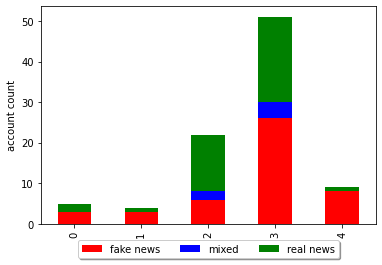

In [105]:
ranks=dfStats_rank.loc[INTERNAL_MEASURES].mean()
bestModelId=np.argmin(ranks)
print("Best model based on INTERNAL metrics:" + ranks.index[bestModelId])
model=models[bestModelId]
cluster_labels = predict_uni(model,data)
contingencytable(dataset_to_process,cluster_labels,true_labels,"internal_"+dataset_to_process)
purity_silhouette(data,cluster_labels,true_labels)


<ipython-input-100-0831c22a3021>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


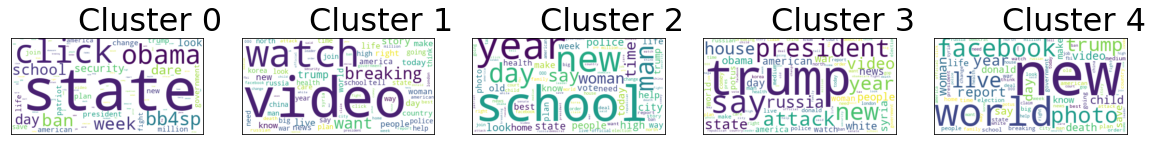

In [106]:
wordcloud(dfFromModel(model,vectorizer),"wordclouds_"+dataset_to_process + "_INTERNAL",max_words=MAX_WORDS_WORDCLOUD)   

<ipython-input-101-513e6e48ef9e>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


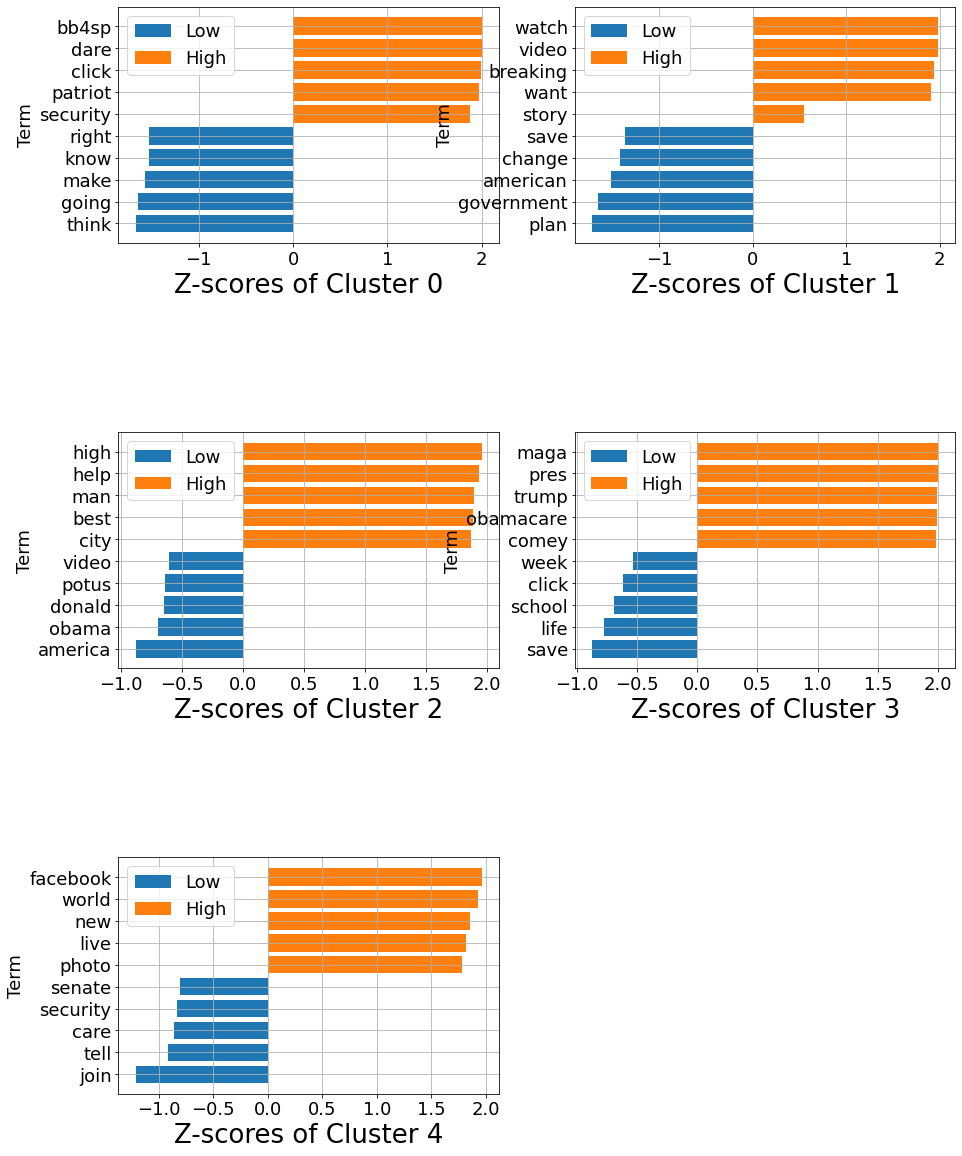

In [107]:
zscore_barchart(dfFromModel(model,vectorizer,"zscore"), "wordclouds_"+dataset_to_process+"_INTERNAL")

<ipython-input-100-0831c22a3021>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


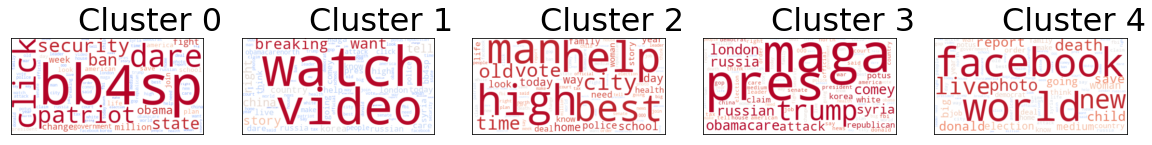

In [108]:
wordcloud(dfFromModel(model,vectorizer,"zscore_rescaled"),"wordclouds_z_"+dataset_to_process+"_INTERNAL", spectral=True,max_words=MAX_WORDS_WORDCLOUD)

## Model selected based on all metrics

Best model based on ALL metrics:k-means++5euclidean


,0,1,2,3,4
silhouette,0.02,0.17,0.08,0.06,-0.08
purity,0.72,0.74,0.70,1.00,0.92


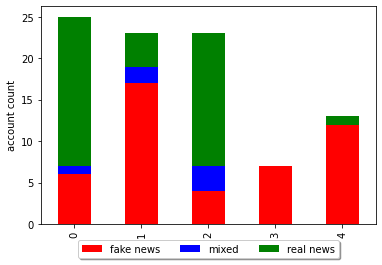

In [109]:
bestModelId=np.argmin(dfStats_rank.mean())
print("Best model based on ALL metrics:" + ranks.index[bestModelId])
model=models[bestModelId]
cluster_labels = predict_uni(model,data)
contingencytable(dataset_to_process,cluster_labels,true_labels,"all_"+dataset_to_process)
purity_silhouette(data,cluster_labels,true_labels)


<ipython-input-100-0831c22a3021>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


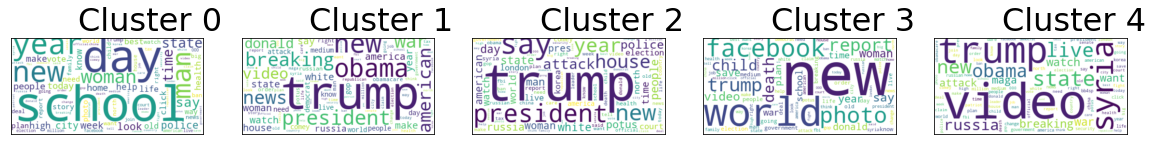

In [110]:
wordcloud(dfFromModel(model,vectorizer),"wordclouds_"+dataset_to_process+"_ALL",max_words=MAX_WORDS_WORDCLOUD)   

<ipython-input-101-513e6e48ef9e>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


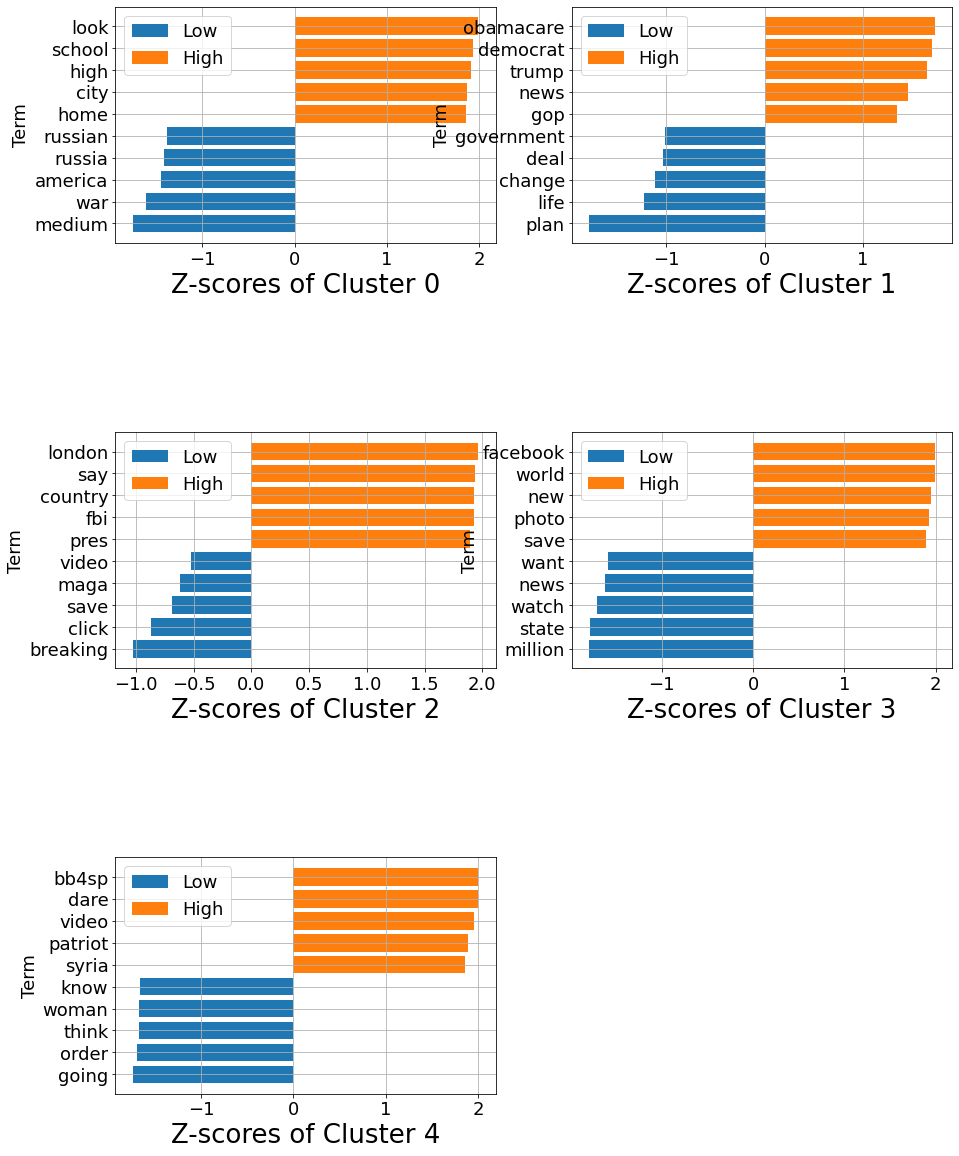

In [111]:
zscore_barchart(dfFromModel(model,vectorizer,"zscore"), "wordclouds_"+dataset_to_process+"_ALL")

<ipython-input-100-0831c22a3021>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


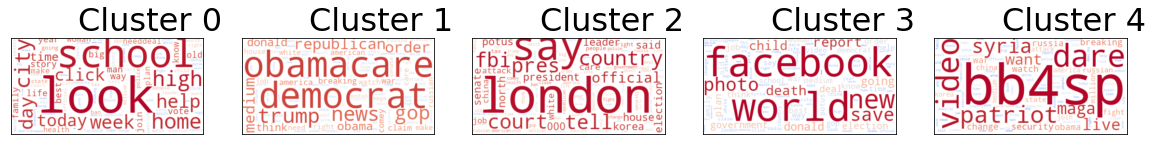

In [112]:
wordcloud(dfFromModel(model,vectorizer,"zscore_rescaled"),"wordclouds_z_"+dataset_to_process+"_ALL", spectral=True,max_words=MAX_WORDS_WORDCLOUD)

## Custom model selection

Overriding automatic selection


<ipython-input-100-0831c22a3021>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-101-513e6e48ef9e>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-100-0831c22a3021>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


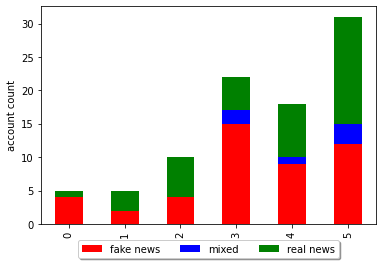

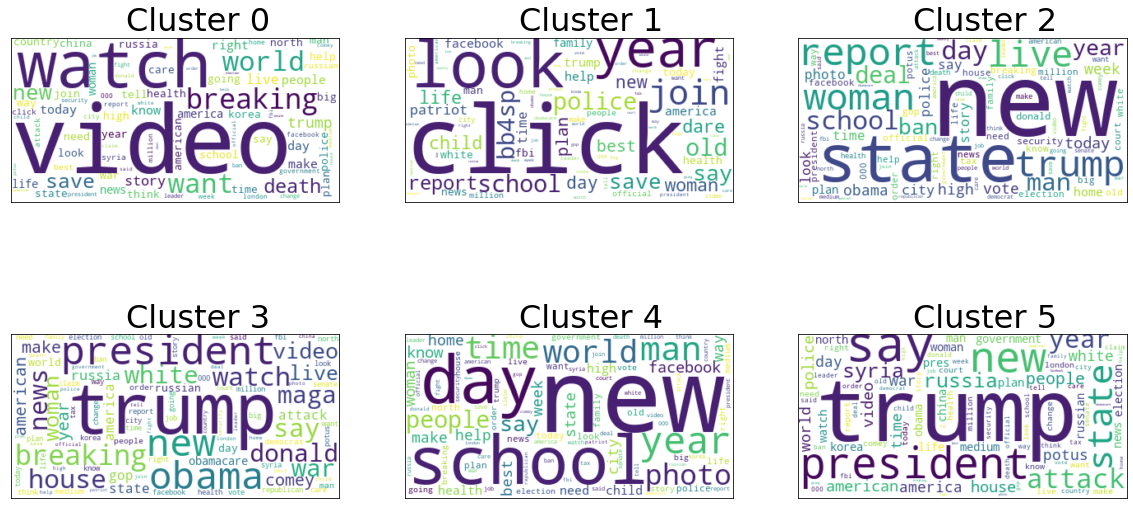

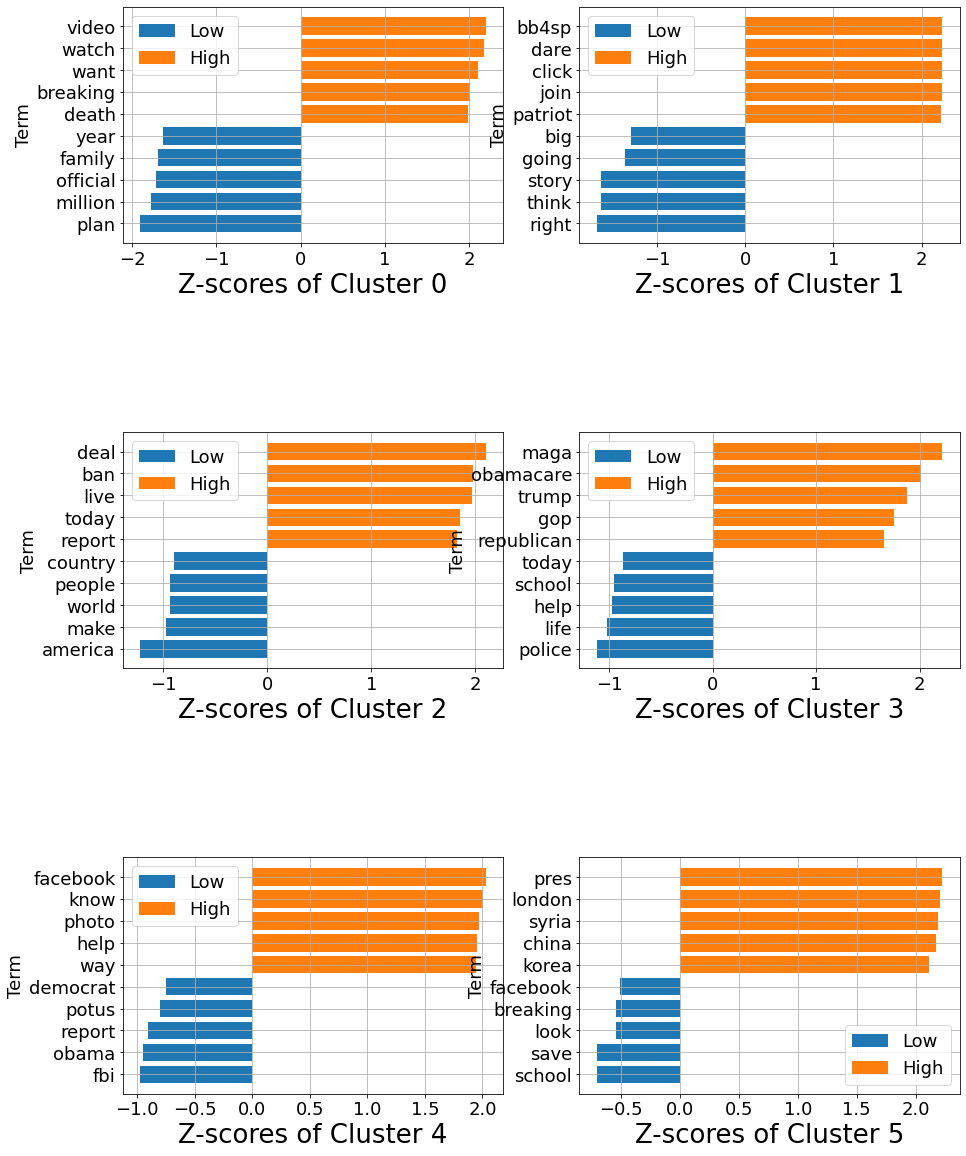

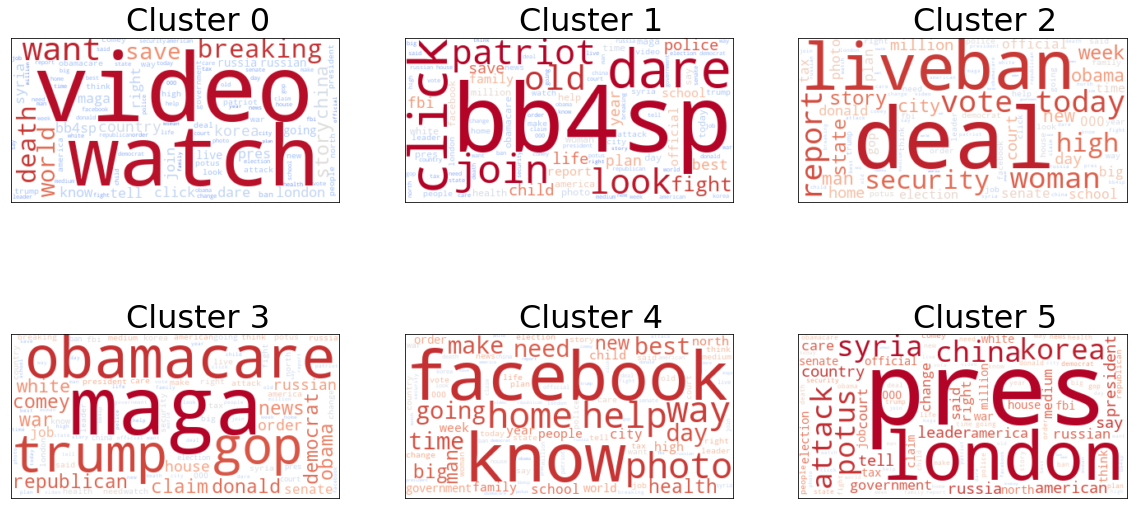

In [113]:
if overrideClusterSelection!=None:
    print("Overriding automatic selection")
    bestModelId = int(np.where(ranks.index==overrideClusterSelection)[0]) #reset to model found as best on the original split
    model=models[bestModelId]
    cluster_labels = predict_uni(model,data)
    contingencytable(dataset_to_process,cluster_labels,true_labels,"all")
    purity_silhouette(data,cluster_labels,true_labels)
    wordcloud(dfFromModel(model,vectorizer),"wordclouds_"+dataset_to_process+overrideClusterSelection,max_words=MAX_WORDS_WORDCLOUD)   
    zscore_barchart(dfFromModel(model,vectorizer,"zscore"), "wordclouds_"+dataset_to_process+overrideClusterSelection)
    wordcloud(dfFromModel(model,vectorizer,"zscore_rescaled"),"wordclouds_z_"+dataset_to_process+overrideClusterSelection, spectral=True,max_words=MAX_WORDS_WORDCLOUD)

# Additional visualizations

In [114]:
if dataset_to_process == "LINVILL":
    #This dataset corresponds to the results of the same workflow as above but on a randomly generated split used for the user study.
    origAnalysis= pd.DataFrame([
    [4,12,39,24,1,2,69,5],
    [0,10,23,8,4,4,77,0],
    [0,13,0,5,18,3,2,1],
    [0,0,1,83,0,0,2,0],
    [0,2,0,5,0,3,133,1],
    [0,0,0,0,24,0,0,0]],
        columns=["Commercial","Fear mongers","Hashtag gamers","Left trolls","News feeds","Non-English","Right trolls","Unknown"]
    )
    plt = origAnalysis.plot
    ax = plt.bar(stacked=True,color= ["blue","pink","black","green","yellow","violet","red","grey"])
    ax.set_ylabel("account count")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    ax.figure.savefig('contingencyLinvill.pdf',bbox_inches='tight')